In [8]:
import sklearn
assert sklearn.__version__>="0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes',labelsize = 14)
mpl.rc('xtick',labelsize = 12)
mpl.rc('ytick',labelsize = 12)


# set the folder where to save images
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,"images","MNIST")
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id,tight_layout=True, fig_extension="png",resolution=300):
    path = os.path.join(IMAGES_PATH,fig_id + "." +fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)    

## MNIST Classification

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version = 1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y= mnist['data'],mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In this dataset, mnist pixel matrices are already flattened. because 28*28=784

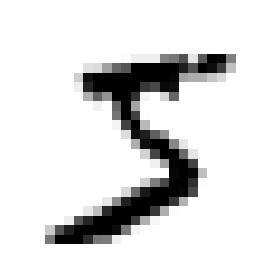

In [9]:
# plot image using flattened features
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = mpl.cm.binary)
plt.axis("off")
save_fig("first_digit_plot")
plt.show()

In [10]:
y[0]

'5'

In [11]:
# output is stored as strings,so to convert it into the int use astype(no.uint8)
y = y.astype(np.uint8)

In [12]:
y[0]

5

In [13]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap = mpl.cm.binary,interpolation = "nearest")
    plt.axis("off")

### this dataset is already randomized, so we can just directly split it into train and test

In [14]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Binary Classifier - Whether a digit is 5 or not

In [15]:
# classify if a digit is 5 or not

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
# SGDClassifier is the linear classifier(SVM, linearRegression) with Stochastic Gradient Descent training.
# By default, it runs Support Vector Machine algorithm
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3,random_state =42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5, cv=3,scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

### accuracy alone cannot be the good indicator of model perfomance. Reason is the imbalanced data, i.e., what if only 10% of the data exists for Positive class and 90% of the training data is for the Negative class. That way, there will always be at least 90% accuracy of the model even if you just guess image is not 4.

To overcome this shortcoming, confusion matrix is preffered. Confusion matrix tells us that how many observations are classified as TN,FP, FN, TP.

In [21]:
from sklearn.model_selection import cross_val_predict
# cross_val_predict perform k -fold cross validation. But instead of evaluation score, it returns the predictions that were made for each validation set.
# This helps to get clean prediction for instance in the training set. here clean means, model had never seen that observation the training step.

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

cm =confusion_matrix(y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

above confusion matrix shows that 
True Negative = 53892
False Positive = 687
False Negative = 1891
True  Positive = 3530

In [26]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred), recall_score(y_train_5,y_train_pred)

(0.8370879772350012, 0.6511713705958311)

In [28]:
# prediction and recamm can also simply calculated from the above confusion matrix array
X_precision = cm[1,1]/(cm[0,1]+cm[1,1])
X_recall = cm[1,1]/(cm[1,0]+cm[1,1])
X_precision, X_recall

(0.8370879772350012, 0.6511713705958311)

In [29]:
f1_score = cm[1,1]/(cm[1,1]+(cm[1,0]+cm[0,1])/2)
f1_score

0.7325171197343847

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

##### f1 score is the harmonic means of the precision and recall. It favors the classifiers that have similar precision and recall. But sometimes we may want to get higher precision, sometimes higher recall. Unfortunately, we cannot get both precision and recall high, because increasing one decreases the other one. This is called precision-recall trade-off.
##### At that point, F1 score may not help.

##### Then we can plot 
- precision-recall vs thresholds curve
- precision vs recall curve
- ROC curve. 

### Plotting Precision and recall with respect to the threshold

In [32]:
# sklearn's predict method returns the classification result. To get the score of each observation for each class, use decision_function() method.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [34]:
threshold = 8000
y_some_digit_pred= (y_scores> threshold)
y_some_digit_pred

array([False])

some_digit = 5 and when we increases the threshold, it was classified as False Negative and this confirms that increasing the threshold, decreases the recall.

To select the threshold for project's targeted precision/recall, make validation predictions for all the training examples, get their score with decision_function, then use presion_recall_curve to compute precision/recall for all possible thresholds:

In [35]:
y_scores = cross_val_predict(sgd_clf,X_train, y_train_5, cv =3,method = "decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

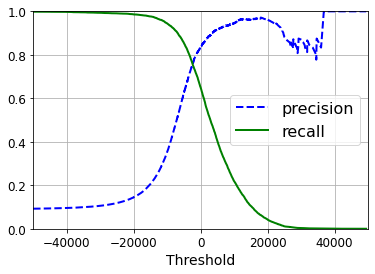

In [44]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="precision",linewidth=2)
    plt.plot(thresholds,recalls[:-1],"g-",label="recall",linewidth=2)
    plt.legend(loc="center right",fontsize=16)
    plt.xlabel("Threshold")
    plt.grid(True)
    plt.axis([-50000,50000,0,1])
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

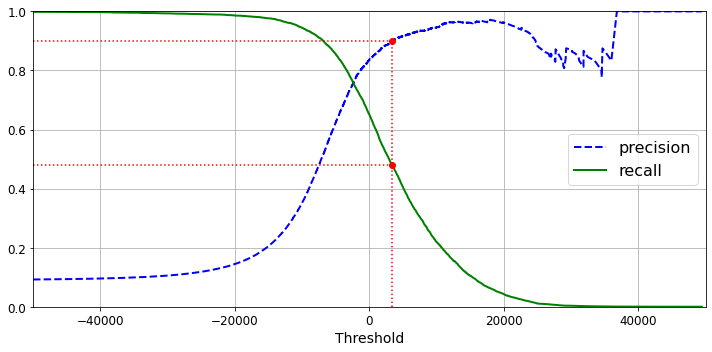

In [69]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(10,5))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.plot([threshold_90_precision,threshold_90_precision],[0.,.9],"r:")
plt.plot([-50000,threshold_90_precision],[0.9,0.9],"r:")
plt.plot([-50000,threshold_90_precision],[recall_90_precision,recall_90_precision],"r:")
plt.plot([threshold_90_precision],[0.9],"ro")
plt.plot([threshold_90_precision],[recall_90_precision],"ro")

save_fig("precision_recall_vs_threshold_plot")

plt.show()

#### As shown in above plot, in order to achieve 90% of the precision, we will have 50% recall. Whether this is acceptable or not, that depends upon the project requirements and should be discussed with the team.

## Precision vs Recall Curve
-helps to detect the value of precision, after which recall starts dropping down much faster.

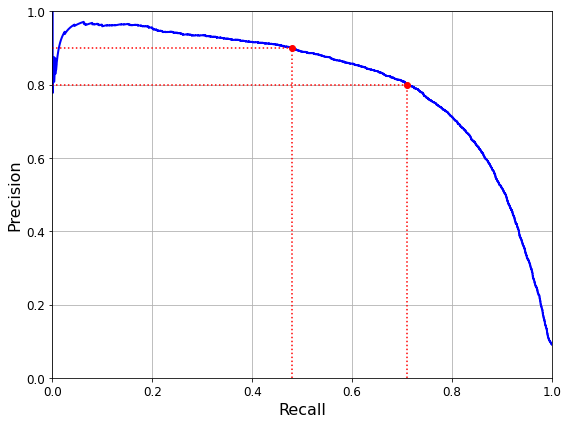

In [79]:
def plot_precision_vs_recall(precisions,recalls):
    plt.plot(recalls,precisions,"b-",linewidth =2)
    plt.xlabel("Recall",fontsize = 16)
    plt.ylabel("Precision",fontsize= 16)
    plt.axis([0,1,0,1])
    plt.grid(True)
    

plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions,recalls)

plt.plot([recall_90_precision,recall_90_precision],[0.,0.9],"r:")
plt.plot([0,recall_90_precision],[0.9,0.9],"r:")
plt.plot([recall_90_precision],[0.9],"ro")

plt.plot([0.71,0.71],[0.,0.8],"r:")
plt.plot([0,0.71],[0.8,0.8],"r:")
plt.plot([0.71],[0.8],"ro")

save_fig("precision_vs_recall_plot")
plt.show() # optional - notebooks calls this function by default

### as precision starts dropping down sharply at 80% recall. select the precision-recall trade-off just before that drop. For example 80%precision with 70%recall

In [81]:
threshold_80_precision = thresholds[np.argmax(precisions >= 0.80)]
threshold_80_precision

-1328.41257665624

In [82]:
y_train_pred_80 = (y_scores >= threshold_80_precision)

precision_score(y_train_5,y_train_pred_80), recall_score(y_train_5,y_train_pred_80)


(0.8, 0.7127836192584394)

### ROC Curve

In [83]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

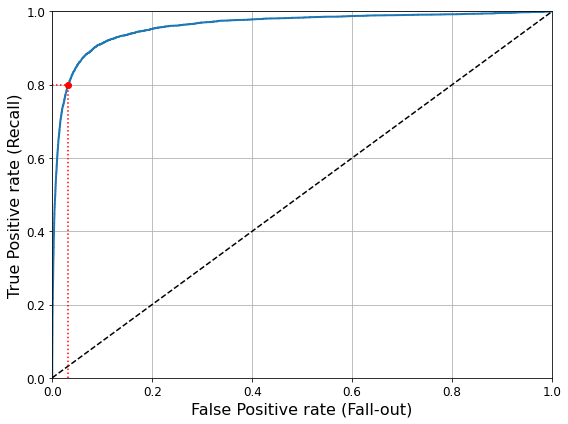

In [85]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2,label = label)
    plt.plot([0,1],[0,1],"k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive rate (Fall-out)",fontsize = 16)
    plt.ylabel("True Positive rate (Recall)",fontsize = 16)
    plt.grid(True)
    
plt.figure(figsize = (8,6))
plot_roc_curve(fpr, tpr)
fpr_80 = fpr[np.argmax(tpr >= 0.8)]
plt.plot([fpr_80,fpr_80],[0.,0.8],"r:")
plt.plot([0.0,fpr_80],[0.8,0.8],"r:")
plt.plot([fpr_80],[0.8],'ro')
save_fig("roc_curve_plot")
plt.show()


In [86]:
# calculate area under curve
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

### Training RandomForest Classifier

In [99]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5, cv= 3,method= "predict_proba")

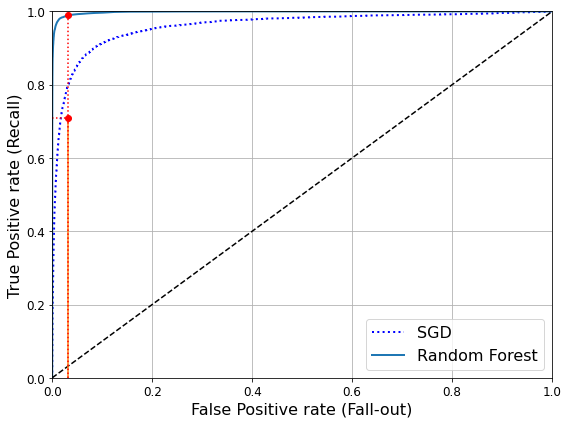

In [105]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

recall_for_forest_80_precision = tpr_forest[np.argmax(fpr_forest >= fpr_80)]

plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,"b:",linewidth=2,label="SGD")

plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")

plt.plot([fpr_80,fpr_80],[0.,0.71])
plt.plot([0,fpr_80],[0.71,0.71],"r:")
plt.plot([fpr_80],[0.71],"ro")

plt.plot([fpr_80,fpr_80],[0,recall_for_forest_80_precision],"r:")
plt.plot([fpr_80],[recall_for_forest_80_precision],"ro")

plt.grid(True)

plt.legend(loc="lower right",fontsize =16)
save_fig("roc_curve_comparison_plot")

plt.show()

In [106]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [108]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train,y_train_5,cv=3)
precision_score(y_train_5,y_train_pred_forest), recall_score(y_train_5,y_train_pred_forest)

(0.9905083315756169, 0.8662608374838591)

# Multiclass classification
- classify all the 10 digits

when we run sklearn.svm for multiclass, sklearn by default executes One vs One at the backend and gets the probability of observation for every class. Then ultimately, returns the one for which value is higher.

In [109]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto",random_state = 42)
svm_clf.fit(X_train[:1000],y_train[:1000])
svm_clf.predict([some_digit])


array([5], dtype=uint8)

In [110]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [112]:
np.argmax(some_digit_scores)  # argmax returns the index of maximum value


5

In [113]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [114]:
svm_clf.classes_[5]

5

In [116]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto",random_state= 42))
ovr_clf.fit(X_train[:1000],y_train[:1000])
ovr_clf.predict([some_digit])

len(ovr_clf.estimators_)

10

In [120]:
sgd_clf.fit(X_train,y_train)


SGDClassifier(random_state=42)

In [121]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [122]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [124]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [126]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring ="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error analysis

In [129]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

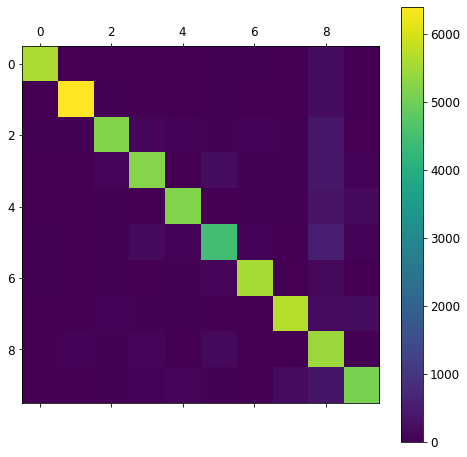

In [131]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(conf_mx)

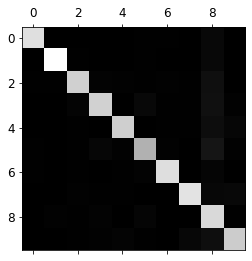

In [132]:
plt.matshow(conf_mx,cmap = plt.cm.gray)
save_fig("confusion_matrix_plot",tight_layout= False)
plt.show()

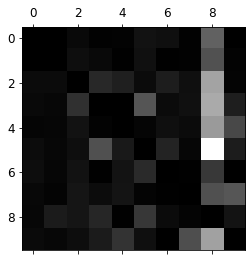

In [133]:
row_sums = conf_mx.sum(axis =1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap= plt.cm.gray)
save_fig("confusion_matrix_error_plot",tight_layout = False)
plt.show()
